### Reference
https://www.tensorflow.org/tutorials/structured_data/time_series

### Import packages

In [1]:
%%time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import IPython
import IPython.display
import pickle

CPU times: user 2.67 s, sys: 6.3 s, total: 8.96 s
Wall time: 37.4 s


### Define global variables

In [2]:
indir = './outputs/tracks-slurm/'
outdir = './outputs/tracks-nns-tmp/'
# outdir = './outputs/tracks-nns/'

### Package the training procedure into a function

In [3]:
multi_val_performance = {}
multi_performance = {}
def model_fit(model, window, max_epochs, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        verbose=1,
                        callbacks=[early_stopping])
    return history, model

### WindowGenerator class

In [4]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, batch_size=32,
                 df=None, ds=None, label_columns=None, column_indices=None):
        self.batch_size = batch_size

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
        # Store the raw data.
        if df is None:
            assert ds is not None and column_indices is not None
            self.ds = ds
            self.column_indices = column_indices
        else:
            self.df = df
            self.column_indices = {name: i for i, name in
                       enumerate(self.df.columns)}
            self.ds = self.make_dataset(self.df)
    
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size,)

        ds = ds.map(self.split_window)

        return ds
    
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    
    def plot(self, model=None, plot_col='xAcceleration', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Step')
    
    
    def get_dataset_partitions_tf(self, ds_size, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=1000):
        
        assert (train_split + test_split + val_split) == 1
        
        # ds_size = len(list(self.ds))
        
        if shuffle:
            # Specify seed to always have the same split distribution between runs
            ds = self.ds.shuffle(shuffle_size, seed=12)

        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train = ds.take(train_size)
        val = ds.skip(train_size).take(val_size)
        test = ds.skip(train_size).skip(val_size)

        return train, val, test
    
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.ds))
            # And cache it for next time
            self._example = result
        return result

## Main

In [5]:
debug_break = False
cnt_break = 200

In [6]:
# Data windowing parameters
# 1-1-1 (single_step_window), 6-1-1 (conv_window), 24-24-1 (wide_window), 26-24-1 (wide_conv_window) 24-24-24 (multi_window)
input_width = 8
label_width = 4
shift = 4

MAX_EPOCHS = 3 if debug_break else 30

locationId = 2
casedir = outdir+f'loc{locationId}_car_{input_width}_{label_width}_{shift}'
os.makedirs(casedir, exist_ok=True)

dsdir = casedir+'/saved_data'
modeldir = casedir+'/saved_model'

print(casedir)

./outputs/tracks-nns-tmp/loc2_car_8_4_4


### Load HighD dataset

In [7]:
%%time
df_meta = pd.read_pickle(indir + 'meta.pkl')
print(df_meta.columns)
print(len(df_meta))
df_meta.head(2)

Index(['recordingId', 'frameRate', 'locationId', 'speedLimit', 'month',
       'weekDay', 'startTime', 'duration', 'totalDrivenDistance',
       'totalDrivenTime', 'numVehicles', 'numCars', 'numTrucks',
       'upperLaneMarkings', 'lowerLaneMarkings'],
      dtype='object')
60
CPU times: user 887 µs, sys: 1.9 ms, total: 2.78 ms
Wall time: 30.5 ms


,recordingId,frameRate,locationId,speedLimit,month,weekDay,startTime,duration,totalDrivenDistance,totalDrivenTime,numVehicles,numCars,numTrucks,upperLaneMarkings,lowerLaneMarkings
0,1,25,2,-1.0,9.2017,Tue,08:38,901.56,418549.19,13908.12,1047,863,184,8.51;12.59;16.43,21.00;24.96;28.80
0,2,25,2,-1.0,9.2017,Tue,09:04,1003.04,445570.50,15080.08,1113,852,261,8.67;12.51;16.35,21.03;24.88;28.72


In [8]:
%%time
df_data = pd.read_pickle(indir + 'data.pkl')
print(df_data.columns)
print(len(df_data))
df_data.head(2)

Index(['recordingId', 'vehicleId', 'width', 'height', 'initialFrame',
       'finalFrame', 'numFrames', 'class', 'drivingDirection',
       'traveledDistance', 'minXVelocity', 'maxXVelocity', 'meanXVelocity',
       'minTTC', 'minTHW', 'minDHW', 'numLaneChanges', 'frame', 'x', 'y',
       'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration',
       'frontSightDistance', 'backSightDistance', 'thw', 'ttc', 'dhw',
       'precedingXVelocity', 'precedingId', 'followingId', 'leftFollowingId',
       'leftAlongsideId', 'leftPrecedingId', 'rightFollowingId',
       'rightAlongsideId', 'rightPrecedingId', 'laneId', 'Left_Pre_X',
       'Left_Pre_Speed', 'Left_Al_X', 'Left_Al_Speed', 'Left_Fol_X',
       'Left_Fol_Speed', 'Right_Pre_X', 'Right_Pre_Speed', 'Right_Al_X',
       'Right_Al_Speed', 'Right_Fol_X', 'Right_Fol_Speed', 'traffic_density',
       'traffic_speed'],
      dtype='object')
110516
CPU times: user 13.4 s, sys: 13.2 s, total: 26.5 s
Wall time: 26.6 s


,recordingId,vehicleId,width,height,initialFrame,finalFrame,numFrames,class,drivingDirection,traveledDistance,...,Left_Fol_X,Left_Fol_Speed,Right_Pre_X,Right_Pre_Speed,Right_Al_X,Right_Al_Speed,Right_Fol_X,Right_Fol_Speed,traffic_density,traffic_speed
0,1,1.0,4.85,2.12,1.0,33.0,33.0,0.0,2.0,52.25,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[120.37, 121.00000000000003, 121.6699999999999...","[23.27, 23.27, 23.26, 23.26, 23.26, 23.26, 23....","[8.254716981132075, 9.433962264150944, 9.43396...","[30.92142857142857, 32.245000000000005, 32.25,..."
1,1,2.0,4.24,1.92,1.0,130.0,130.0,0.0,1.0,167.44,...,"[104.58999999999997, 104.17999999999998, 103.7...","[42.72, 42.73, 42.73, 42.73, 42.74, 42.74, 42....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.89622641509434, 7.0754716981132075, 7.07547...","[36.922000000000004, 37.19833333333334, 37.208..."


Text(0.5, 0, 'numFrames (0-Car, 1-Others)')

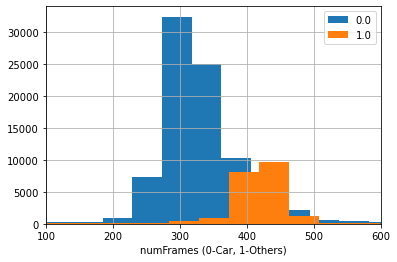

In [9]:
df_data.groupby('class').numFrames.hist(bins=50, legend=True)
plt.xlim(100, 600)
plt.xlabel('numFrames (0-Car, 1-Others)')

### Select data

In [10]:
df_truck = df_data.loc[(df_data['class'] == 1) & (df_data['numFrames'] >= 200) & (df_data['numFrames'] <= 500)].reset_index(drop=True)
print(len(df_truck))
df_truck.head(2)

20329


,recordingId,vehicleId,width,height,initialFrame,finalFrame,numFrames,class,drivingDirection,traveledDistance,...,Left_Fol_X,Left_Fol_Speed,Right_Pre_X,Right_Pre_Speed,Right_Al_X,Right_Al_Speed,Right_Fol_X,Right_Fol_Speed,traffic_density,traffic_speed
0,1,10.0,9.20,2.5,1.0,232.0,232.0,1.0,2.0,210.46,...,"[19.22999999999999, 18.79000000000002, 18.3400...","[35.69, 35.69, 35.7, 35.71, 35.71, 35.72, 35.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.254716981132075, 9.433962264150944, 9.43396...","[30.92142857142857, 32.245000000000005, 32.25,..."
1,1,22.0,7.98,2.5,280.0,697.0,418.0,1.0,1.0,408.52,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.716981132075472, 4.716981132075472, 4.71698...","[34.4525, 34.45, 34.4425, 34.435, 34.43, 34.41..."


In [11]:
df_car = df_data.loc[(df_data['class'] == 0) & (df_data['numFrames'] >= 200) & (df_data['numFrames'] <= 500)].reset_index(drop=True)
print(len(df_car))
df_car.head(2)

84843


,recordingId,vehicleId,width,height,initialFrame,finalFrame,numFrames,class,drivingDirection,traveledDistance,...,Left_Fol_X,Left_Fol_Speed,Right_Pre_X,Right_Pre_Speed,Right_Al_X,Right_Al_Speed,Right_Fol_X,Right_Fol_Speed,traffic_density,traffic_speed
0,1,9.0,4.85,2.02,1.0,223.0,223.0,0.0,1.0,323.25,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.89622641509434, 7.0754716981132075, 7.07547...","[36.922000000000004, 37.19833333333334, 37.208..."
1,1,11.0,4.14,1.92,1.0,235.0,235.0,0.0,2.0,231.76,...,"[29.960000000000008, 29.659999999999997, 29.38...","[32.59, 32.6, 32.61, 32.62, 32.64, 32.65, 32.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.254716981132075, 9.433962264150944, 9.43396...","[30.92142857142857, 32.245000000000005, 32.25,..."


In [12]:
df = df_car
recIdSet = df_meta.loc[df_meta['locationId']==locationId, 'recordingId'].to_list()
df = df.loc[df['recordingId'].isin(recIdSet)]
print(f'\n recIdSet={recIdSet}')
df.head(2)


 recIdSet=[1, 2, 3]


,recordingId,vehicleId,width,height,initialFrame,finalFrame,numFrames,class,drivingDirection,traveledDistance,...,Left_Fol_X,Left_Fol_Speed,Right_Pre_X,Right_Pre_Speed,Right_Al_X,Right_Al_Speed,Right_Fol_X,Right_Fol_Speed,traffic_density,traffic_speed
0,1,9.0,4.85,2.02,1.0,223.0,223.0,0.0,1.0,323.25,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.89622641509434, 7.0754716981132075, 7.07547...","[36.922000000000004, 37.19833333333334, 37.208..."
1,1,11.0,4.14,1.92,1.0,235.0,235.0,0.0,2.0,231.76,...,"[29.960000000000008, 29.659999999999997, 29.38...","[32.59, 32.6, 32.61, 32.62, 32.64, 32.65, 32.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.254716981132075, 9.433962264150944, 9.43396...","[30.92142857142857, 32.245000000000005, 32.25,..."


In [13]:
df_stat = df.loc[:, 'recordingId':'numLaneChanges']
print(len(df_stat))
df_stat.head(2)

2362


,recordingId,vehicleId,width,height,initialFrame,finalFrame,numFrames,class,drivingDirection,traveledDistance,minXVelocity,maxXVelocity,meanXVelocity,minTTC,minTHW,minDHW,numLaneChanges
0,1,9.0,4.85,2.02,1.0,223.0,223.0,0.0,1.0,323.25,35.99,36.62,36.42,9.74,0.92,33.68,1.0
1,1,11.0,4.14,1.92,1.0,235.0,235.0,0.0,2.0,231.76,23.86,26.90,24.79,3.16,0.30,7.44,1.0


In [14]:
df_traj = pd.concat([df.loc[:, 'frame':'traffic_speed'], df.loc[:, 'recordingId':'vehicleId']], axis=1)
print(len(df_traj))
df_traj.head(2)

2362


,frame,x,y,xVelocity,yVelocity,xAcceleration,yAcceleration,frontSightDistance,backSightDistance,thw,...,Right_Pre_X,Right_Pre_Speed,Right_Al_X,Right_Al_Speed,Right_Fol_X,Right_Fol_Speed,traffic_density,traffic_speed,recordingId,vehicleId
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[317.48, 316.16, 314.78, 313.38, 311.96, 310.5...","[9.44, 9.44, 9.43, 9.43, 9.43, 9.43, 9.42, 9.4...","[35.99, 35.99, 36.0, 36.01, 36.01, 36.02, 36.0...","[-0.09, -0.08, -0.08, -0.07, -0.07, -0.06, -0....","[0.16, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.1...","[0.02, 0.03, 0.05, 0.06, 0.07, 0.09, 0.1, 0.11...","[319.75, 318.29, 316.77, 315.41, 313.89, 312.3...","[92.07, 93.53, 95.05, 96.41, 97.93, 99.44, 100...","[2.02, 2.01, 2.01, 2.0, 2.0, 1.99, 1.98, 1.98,...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.89622641509434, 7.0754716981132075, 7.07547...","[36.922000000000004, 37.19833333333334, 37.208...",1,9.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[181.5, 182.39, 183.33, 184.31, 185.29, 186.28...","[25.49, 25.49, 25.49, 25.5, 25.5, 25.51, 25.51...","[25.07, 25.06, 25.05, 25.03, 25.02, 25.01, 25....","[0.09, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.0...","[-0.29, -0.29, -0.29, -0.29, -0.29, -0.28, -0....","[-0.01, -0.02, -0.02, -0.03, -0.04, -0.04, -0....","[229.0, 228.14, 227.18, 226.02, 225.11, 224.1,...","[182.82, 183.68, 184.64, 185.8, 186.71, 187.72...","[0.62, 0.62, 0.62, 0.62, 0.62, 0.61, 0.61, 0.6...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.254716981132075, 9.433962264150944, 9.43396...","[30.92142857142857, 32.245000000000005, 32.25,...",1,11.0


In [ ]:
del df_meta, df_data, df_truck, df_car, df, df_stat

### Pre-process data

In [15]:
if os.path.exists(casedir+'/df_flatten.pkl'):
    df_flatten = pd.read_pickle(casedir+'/df_flatten.pkl')
    print('\n df_flatten loaded!')
else:
    df_flatten = pd.DataFrame()
    for idx, row in tqdm(df_traj.iterrows(), total=df_traj.shape[0], mininterval=5):
        df_ = pd.DataFrame()
        for col_name, col_val in row.iteritems():
            if col_name not in ['precedingId', 'followingId', 'leftFollowingId', 'leftAlongsideId',
                                'leftPrecedingId', 'rightFollowingId', 'rightAlongsideId', 'rightPrecedingId']:
                df_[col_name] = col_val
        df_ = df_[5::6]
        if idx == 0:
            df_flatten = df_
        else:
            df_flatten = pd.concat([df_flatten, df_])

        if debug_break and idx == cnt_break:
            break
    
    rec_col = df_flatten.pop('recordingId').astype('int')
    veh_col = df_flatten.pop('vehicleId').astype('int')
    df_flatten.insert(0, 'recVehId', list(zip(rec_col, veh_col)))
    
    df_flatten.to_pickle(casedir+'/df_flatten.pkl')
    print('\n df_flatten saved!')
    print(f'\n df_flatten length: {len(df_flatten)}')
    del df_traj

df_flatten

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2362/2362 [00:17<00:00, 138.24it/s]



 df_flatten saved!

 df_flatten length: 122121


,recVehId,frame,x,y,xVelocity,yVelocity,xAcceleration,yAcceleration,frontSightDistance,backSightDistance,...,Left_Fol_X,Left_Fol_Speed,Right_Pre_X,Right_Pre_Speed,Right_Al_X,Right_Al_Speed,Right_Fol_X,Right_Fol_Speed,traffic_density,traffic_speed
5,"(1, 9)",6,310.52,9.43,36.02,-0.06,0.18,0.09,312.38,99.44,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,7.075472,37.241667
11,"(1, 9)",12,301.85,9.42,36.07,-0.01,0.19,0.16,303.74,108.08,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,7.075472,37.320000
17,"(1, 9)",18,293.18,9.42,36.11,0.05,0.19,0.22,295.04,116.77,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,7.075472,37.391667
23,"(1, 9)",24,284.49,9.44,36.15,0.13,0.18,0.26,286.35,125.47,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,7.075472,37.456667
29,"(1, 9)",30,275.80,9.49,36.20,0.22,0.18,0.29,277.66,134.16,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,5.896226,37.170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,"(3, 911)",25206,37.48,12.97,39.00,0.07,0.22,0.07,35.96,372.76,...,0.0,0.0,8.67,24.76,0.00,0.00,28.99,27.61,4.716981,32.782500
239,"(3, 911)",25212,28.11,12.99,39.05,0.08,0.21,0.07,26.66,382.06,...,0.0,0.0,0.00,0.00,5.23,24.74,31.75,27.48,4.716981,32.767500
245,"(3, 911)",25218,18.78,13.00,39.10,0.10,0.21,0.07,17.36,391.46,...,0.0,0.0,0.00,0.00,1.83,24.73,34.51,27.35,3.537736,30.393333
251,"(3, 911)",25224,9.40,13.03,39.15,0.12,0.22,0.07,7.97,400.75,...,0.0,0.0,0.00,0.00,1.62,24.71,37.34,27.22,3.537736,30.360000


### Data windowing

In [ ]:
%%time
if os.path.exists(dsdir):
    ds_load = tf.data.experimental.load(dsdir)
    with open(casedir+'/ds_size.txt', 'r') as f:
        ds_size = int(f.readline())
    with open(casedir+'/column_indices.pkl', 'rb') as f:
        cols_load = pickle.load(f)

    w = WindowGenerator(input_width=input_width, label_width=label_width, shift=shift, ds=ds_load,
                        label_columns=['xAcceleration'], column_indices=cols_load)
    print('\n Data loaded!')
else:
    col_drop = ['recVehId', 'frame']
    df_mean = df_flatten.drop(col_drop, axis=1).mean()
    df_std = df_flatten.drop(col_drop, axis=1).std()
    ds_size = 0
    w = None
    for val in tqdm(df_flatten['recVehId'].unique(), mininterval=10):
        df_ = df_flatten.loc[df_flatten['recVehId']==val].drop(col_drop, axis=1)
        df_ = (df_ - df_mean) / df_std

        w_ = WindowGenerator(input_width=input_width, label_width=label_width, shift=shift, df=df_,
                             label_columns=['xAcceleration'])
        ds_size += len(list(w_.ds))
        if w == None:
            w = w_
            print(w)
        else:
            w.ds = w.ds.concatenate(w_.ds)
        
    del df_flatten
    print('\n Data created!')
    print(f'\n Dataset size: {ds_size}')
    tf.data.experimental.save(w.ds, dsdir)
    with open(casedir+'/ds_size.txt', 'w') as f:
        f.write('%d' % ds_size)
    with open(casedir+'/column_indices.pkl', 'wb') as f:
        pickle.dump(w.column_indices, f)
    print('\n Data saved!')

  0%|                                                                                                                                                                                 | 0/2362 [00:00<?, ?it/s]2022-08-22 17:28:28.699739: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 17:28:28.922198: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Total window size: 12
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11]
Label column name(s): ['xAcceleration']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2362/2362 [04:22<00:00,  9.00it/s]



 Data created!

 Dataset size: 4435


In [ ]:
w.train, w.val, w.test = w.get_dataset_partitions_tf(ds_size)
print('\n Data splitted!')

### Traing neural networks

In [ ]:
num_features = len(w.column_indices)
OUT_STEPS = w.label_width

if os.path.exists(modeldir+'/my_model'):
    multi_lstm_model = tf.keras.models.load_model(modeldir+'/my_model')
    print('\n Model loaded!')
else:
    multi_lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    multi_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
    print('\n Model created!')
    
history, model = model_fit(multi_lstm_model, w, MAX_EPOCHS)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = model.evaluate(w.val)
multi_performance['LSTM'] = model.evaluate(w.test, verbose=2)

model.summary()
model.save(modeldir+'/my_model')
print('\n Model saved!')
w.plot(model)